<a href="https://colab.research.google.com/github/Avelez164/Data-Science-Big-Data/blob/main/CPSC_375_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Group Names:

*   Antonio Velez
*   Farren Tanudjaja


In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

# Data wrangling

Datasets

1. Data on COVID-19 from Our World in Data
Their complete dataset contains a lot of information including the number of deaths, cases, vaccinations, hospitalizations, and several other country-specific pieces of information relevant to understanding the effects of COVID. Note that you can read the “raw” CSV file from a URL directly, like so:
pd.read_csv("https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv")

In [ ]:
df_covid = pd.read_csv("https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv")
df_covid['date'] = pd.to_datetime(df_covid['date'])

# Display the first few rows
df_covid.head()


,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,population,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-01-05,0.0,0.0,NaN,0.0,0.0,NaN,...,NaN,37.75,0.5,64.83,0.51,41128772,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-01-06,0.0,0.0,NaN,0.0,0.0,NaN,...,NaN,37.75,0.5,64.83,0.51,41128772,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-01-07,0.0,0.0,NaN,0.0,0.0,NaN,...,NaN,37.75,0.5,64.83,0.51,41128772,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-01-08,0.0,0.0,NaN,0.0,0.0,NaN,...,NaN,37.75,0.5,64.83,0.51,41128772,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-01-09,0.0,0.0,NaN,0.0,0.0,NaN,...,NaN,37.75,0.5,64.83,0.51,41128772,NaN,NaN,NaN,NaN


2. Population estimates from The World Bank Group’s DataBank


In [ ]:
import pandas as pd

url_population = "https://docs.google.com/spreadsheets/d/1TTtVxlJWiE7iGpaPRFy1EQ85AMQczZOvTr6kSx4Nxsk/export?format=csv"
df_population = pd.read_csv(url_population)

# Display the first few rows
df_population.head()


,Country Name,Country Code,Series Name,Series Code,2022 [YR2022],2023 [YR2023]
0,Afghanistan,AFG,"Population ages 80 and above, female",SP.POP.80UP.FE,62400,65171
1,Afghanistan,AFG,"Population ages 80 and above, male",SP.POP.80UP.MA,41192,42889
2,Afghanistan,AFG,Rural population,SP.RUR.TOTL,29778377,30289750
3,Afghanistan,AFG,Urban population,SP.URB.TOTL,10800465,11165011
4,Afghanistan,AFG,"Population ages 65 and above, total",SP.POP.65UP.TO,955689,985603


In [ ]:
# these are all the Series (variables) that I selected relevant to predicting death from COVID
df_population['Series Name'].unique()


array(['Population ages 80 and above, female',
       'Population ages 80 and above, male', 'Rural population',
       'Urban population', 'Population ages 65 and above, total',
       'Population ages 65 and above, male',
       'Population ages 65 and above, female'], dtype=object)

a) read the two data files using pd.read_csv()

In [ ]:
#1st dataset
df_covid = pd.read_csv("https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv")
df_covid['date'] = pd.to_datetime(df_covid['date'])

#2nd dataset
url_population = "https://docs.google.com/spreadsheets/d/1O-GjD1mzku9RLnfqDpeRbJ4xfoiTMZzkx6iexe7o1bc/export?format=csv"
df_population = pd.read_csv(url_population)


b) Keep only country-level data by removing all rows where the country_code is not exactly 3 letters (these represent larger regions like continents). Hint: .str.len() returns the number of characters.

In [ ]:
df_covid = df_covid[df_covid['iso_code'].str.len() == 3]


c) Remove countries whose total population is less than 1 million.

In [ ]:
df_covid = df_covid[df_covid['population'] >= 1_000_000]


d) Add a new column new_deaths_smoothed_2wk that has the same values as new_deaths_smoothed but two weeks ahead (will be used for linear modeling as described later). Pandas has a pd.to_datetime() function and pd.Timedelta object that enable calculations with dates like .assign(date=date - pd.Timedelta(14)) and .query('date >= "2023-01-01"').

In [ ]:
# Ensures date -> datetime type
df_covid['date'] = pd.to_datetime(df_covid['date'])


# Create shifted deaths column
df_shifted = (
    df_covid[['iso_code', 'date', 'new_deaths_smoothed']].copy()
    .dropna(subset=['new_deaths_smoothed'])  #drop missing deaths
    .assign(date=lambda x: x['date'] - pd.Timedelta(days=14))
    .drop_duplicates(subset=['iso_code', 'date'])
    .rename(columns={'new_deaths_smoothed': 'new_deaths_smoothed_2wk'})
)

df_covid = df_covid.drop(
    columns=['new_deaths_smoothed_2wk'], errors='ignore'
)

# now merge
df_covid = pd.merge(
    df_covid,
    df_shifted,
    on=['iso_code', 'date'],
    how='left'
)



e) tidy tables, as needed. (Hint: only the population data is not tidy.)

In [ ]:
df_population_tidy = (
    df_population[['Country Code', 'Series Name', '2023 [YR2023]']]
    .pivot(index='Country Code', columns='Series Name', values='2023 [YR2023]')
    .reset_index()
)


f) Merge the tables (Hint: merge using the 3-letter ISO code)

In [ ]:
df_final = pd.merge(
    df_covid,
    df_population_tidy,
    left_on='iso_code',
    right_on='Country Code',
    how='inner'
).drop(columns=['Country Code'])

In [ ]:
# --- Final cleanup before modeling ---

columns_to_drop = ['location_y', 'continent', 'Unnamed: 0']  # Add more if you spot any extras
df_final = df_final.drop(columns=[col for col in columns_to_drop if col in df_final.columns])

if 'location_x' in df_final.columns:
    df_final = df_final.rename(columns={'location_x': 'location'})

df_final['date'] = pd.to_datetime(df_final['date'])

duplicates = df_final.duplicated(subset=['iso_code', 'date'])
print(f"Duplicate rows found: {duplicates.sum()}")
df_final = df_final.drop_duplicates(subset=['iso_code', 'date'])

key_vars = [
    'new_cases_smoothed',
    'new_deaths_smoothed_2wk',
    'gdp_per_capita',
    'diabetes_prevalence',
    #'icu_patients',
    'population',
    'Population ages 80 and above, female',
    'Population ages 80 and above, male'
]

missing_cols = [col for col in key_vars if col not in df_final.columns]
print("Missing columns:", missing_cols)

print("\nProportion of missing values in key variables:")
print(df_final[[col for col in key_vars if col in df_final.columns]].isna().mean().sort_values(ascending=False))

df_final.to_csv("cleaned_df_final.csv", index=False)


Duplicate rows found: 1014
Missing columns: []

Proportion of missing values in key variables:
gdp_per_capita                          0.025312
new_deaths_smoothed_2wk                 0.019275
new_cases_smoothed                      0.015643
diabetes_prevalence                     0.006328
population                              0.000000
Population ages 80 and above, female    0.000000
Population ages 80 and above, male      0.000000
dtype: float64


In [ ]:
# columns to preview
columns_to_display = [
    'iso_code', 'location', 'date', 'new_deaths_smoothed_2wk',
    'new_cases', 'new_cases_smoothed', 'total_vaccinations'
]

# adds population predictors
predictor_columns = df_population_tidy.columns.difference(['Country Code']).tolist()
columns_to_display += predictor_columns[:5]

# display first few rows
df_final[columns_to_display]


,iso_code,location,date,new_deaths_smoothed_2wk,new_cases,new_cases_smoothed,total_vaccinations,"Age dependency ratio, old","Age dependency ratio, young","Death rate, crude (per 1,000 people)","Life expectancy at birth, female (years)","Life expectancy at birth, male (years)"
0,AFG,Afghanistan,2020-01-05,0.0,0.0,NaN,NaN,4.370776217,79.46539663,..,..,..
1,AFG,Afghanistan,2020-01-06,0.0,0.0,NaN,NaN,4.370776217,79.46539663,..,..,..
2,AFG,Afghanistan,2020-01-07,0.0,0.0,NaN,NaN,4.370776217,79.46539663,..,..,..
3,AFG,Afghanistan,2020-01-08,0.0,0.0,NaN,NaN,4.370776217,79.46539663,..,..,..
4,AFG,Afghanistan,2020-01-09,0.0,0.0,NaN,NaN,4.370776217,79.46539663,..,..,..
...,...,...,...,...,...,...,...,...,...,...,...,...
265544,ZWE,Zimbabwe,2024-07-31,NaN,0.0,0.0,NaN,6.57179498,75.05355678,..,..,..
265545,ZWE,Zimbabwe,2024-08-01,NaN,0.0,0.0,NaN,6.57179498,75.05355678,..,..,..
265546,ZWE,Zimbabwe,2024-08-02,NaN,0.0,0.0,NaN,6.57179498,75.05355678,..,..,..
265547,ZWE,Zimbabwe,2024-08-03,NaN,0.0,0.0,NaN,6.57179498,75.05355678,..,..,..


# Linear modeling

The goal is to predict new_deaths_smoothed two weeks in the future. Hint: this is the dependent variable.


a) Make a list of all predictor variables that are available. The challenge is to identify which combination of these predictors will give the best predictive model.


In [ ]:
numeric_cols = df_final.select_dtypes(include=[np.number]).columns.tolist()
predictor_vars = [col for col in numeric_cols if col != 'new_deaths_smoothed_2wk']
print("Available predictor variables:")
for v in predictor_vars:
    print(" •", v)


Available predictor variables:
 • total_cases
 • new_cases
 • new_cases_smoothed
 • total_deaths
 • new_deaths
 • new_deaths_smoothed
 • total_cases_per_million
 • new_cases_per_million
 • new_cases_smoothed_per_million
 • total_deaths_per_million
 • new_deaths_per_million
 • new_deaths_smoothed_per_million
 • reproduction_rate
 • icu_patients
 • icu_patients_per_million
 • hosp_patients
 • hosp_patients_per_million
 • weekly_icu_admissions
 • weekly_icu_admissions_per_million
 • weekly_hosp_admissions
 • weekly_hosp_admissions_per_million
 • total_tests
 • new_tests
 • total_tests_per_thousand
 • new_tests_per_thousand
 • new_tests_smoothed
 • new_tests_smoothed_per_thousand
 • positive_rate
 • tests_per_case
 • total_vaccinations
 • people_vaccinated
 • people_fully_vaccinated
 • total_boosters
 • new_vaccinations
 • new_vaccinations_smoothed
 • total_vaccinations_per_hundred
 • people_vaccinated_per_hundred
 • people_fully_vaccinated_per_hundred
 • total_boosters_per_hundred
 • new_

b) Generate some (at least 3) transformed variables. E.g., these could combine variables (e.g., cardiovasc_deaths= cardiovasc_death_rate*population).


In [ ]:
# converts columns to numeric
df_final['Population ages 80 and above, female'] = pd.to_numeric(df_final['Population ages 80 and above, female'], errors='coerce')
df_final['Population ages 80 and above, male'] = pd.to_numeric(df_final['Population ages 80 and above, male'], errors='coerce')
df_final['population'] = pd.to_numeric(df_final['population'], errors='coerce')
df_final['new_cases_smoothed'] = pd.to_numeric(df_final['new_cases_smoothed'], errors='coerce')


In [ ]:
# Merge with your 2023 population data
df_final = pd.merge(
    df_covid,
    df_population_tidy,
    left_on="iso_code",
    right_on="Country Code",
    how="inner"
).drop(columns=["Country Code"])

# Convert necessary fields to numeric
cols_to_convert = [
    "Population ages 80 and above, female",
    "Population ages 80 and above, male",
    "population",
    "new_cases_smoothed",
    "new_deaths_smoothed",
    "gdp_per_capita",
    "diabetes_prevalence"
]
for col in cols_to_convert:
    df_final[col] = pd.to_numeric(df_final[col], errors='coerce')

# Create transformed features
df_final['elderly_pop_80_plus'] = (
    df_final['Population ages 80 and above, female'] +
    df_final['Population ages 80 and above, male']
)
df_final['elderly_ratio'] = df_final['elderly_pop_80_plus'] / df_final['population']
df_final['new_cases_per_100k'] = (df_final['new_cases_smoothed'] / df_final['population']) * 100000


c) Split your dataset into train and test subsets: only data from 2022 should be used for building/training the linear models in sm.formula.ols(). (Data from 2023 will be used for evaluation as described later). Note: each day is one data point.


In [ ]:
from sklearn.model_selection import train_test_split

# Assuming your DataFrame is named 'df_final' and has a 'date' column

# Convert the 'date' column to datetime objects if it's not already
df_final['date'] = pd.to_datetime(df_final['date'])

train_data = df_final[df_final['date'].dt.year == 2022].copy()
test_data  = df_final[
    (df_final['date'].dt.year == 2023) &
    (df_final['date'].dt.month <= 6)
].copy()

# You can further split the train_data into features (X) and target (y)
X_train = train_data[['new_cases_smoothed', 'gdp_per_capita', 'diabetes_prevalence', 'icu_patients']]
y_train = train_data['new_deaths_smoothed_2wk']

X_test = test_data[['new_cases_smoothed', 'gdp_per_capita', 'diabetes_prevalence', 'icu_patients']]
y_test = test_data['new_deaths_smoothed_2wk']

d) Run linear regression with at least 5 different combinations of predictor variables.

Hint: each model will look like:
new_deaths_smoothed_2wk~new_cases_smoothed+gdp_per_capita+diabetes_prevalence+icu_patients+Q("SP.URB.TOTL")


In [ ]:
import statsmodels.formula.api as smf

model_specs = {
    'M1_cases_gdp_diab_icu':      ['new_cases_smoothed','gdp_per_capita','diabetes_prevalence','icu_patients'],
    'M2_cases_elderly_diab_icu':  ['new_cases_smoothed','elderly_ratio','diabetes_prevalence','icu_patients'],
    'M3_cases100k_elderly_loggdp':['new_cases_per_100k','elderly_ratio','gdp_per_capita','diabetes_prevalence'],
    'M4_cases_vacc_elderly':      ['new_cases_smoothed','total_vaccinations','elderly_ratio'],
    'M5_cases100k_loggdp_elderly':['new_cases_per_100k','gdp_per_capita','elderly_pop_80_plus']
}

fitted_models = {}
for name, preds in model_specs.items():
    terms = [f'Q("{v}")' if " " in v else v for v in preds]
    formula = 'new_deaths_smoothed_2wk ~ ' + ' + '.join(terms)
    fitted_models[name] = smf.ols(formula, data=train_data).fit()


In [ ]:
# Extract in‐sample R² for each model

r2_scores = {name: mod.rsquared for name, mod in fitted_models.items()}

print("Training R² (2022) for each model:")
for name, r2 in r2_scores.items():
    print(f"  {name:<30} R² = {r2:.3f}")


Training R² (2022) for each model:
  M1_cases_gdp_diab_icu          R² = 0.885
  M2_cases_elderly_diab_icu      R² = 0.884
  M3_cases100k_elderly_loggdp    R² = 0.055
  M4_cases_vacc_elderly          R² = 0.287
  M5_cases100k_loggdp_elderly    R² = 0.185


# Evaluating the linear models


You should evaluate each of your linear models by predicting the number of daily deaths in each day in January-June 2023 (the test data) and comparing it with the actual number of deaths on those days. Specifically:


a) For each of your models, calculate the Root Mean Squared Error (RMSE) over all days in January-June 2023 and all countries. Hint: use

sm.tools.eval_measures.rmse() or sklearn.metrics.root_mean_squared_error().


In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm  # for sm.tools.eval_measures.rmse()

rmses = {}

for name, model in fitted_models.items():
    y_true = test_data['new_deaths_smoothed_2wk']
    y_pred = model.predict(test_data)

    mask = (~y_true.isna()) & (~pd.Series(y_pred, index=y_true.index).isna())
    y_true_clean = y_true[mask]
    y_pred_clean = y_pred[mask]

    rmse_val = sm.tools.eval_measures.rmse(y_true_clean, y_pred_clean)

    rmses[name] = rmse_val

print("Overall RMSE on Jan–Jun 2023:")
for name, rmse in rmses.items():
    print(f"  {name:<30} RMSE = {rmse:.2f}")


Overall RMSE on Jan–Jun 2023:
  M1_cases_gdp_diab_icu          RMSE = 35.45
  M2_cases_elderly_diab_icu      RMSE = 35.30
  M3_cases100k_elderly_loggdp    RMSE = 114.64
  M4_cases_vacc_elderly          RMSE = 162.03
  M5_cases100k_loggdp_elderly    RMSE = 111.82


b) For only your best model, calculate the Root Mean Squared Error for every country. Hint: use .groupby(), then .apply() the RMSE to each group.


In [ ]:
# Assuming 'M3_cases100k_elderly_loggdp' is the best model
best_model = fitted_models['M3_cases100k_elderly_loggdp']

# Extract predictor columns used in the model
terms = best_model.model.exog_names[1:]  # Exclude the intercept term
preds = [t.strip('Q("').strip('")') for t in terms]

# Define a function to calculate RMSE for a group (country)
def calculate_rmse(group):
    X_test_group = group[preds]
    predictions_group = best_model.predict(X_test_group)
    rmse = sm.tools.eval_measures.rmse(group['new_deaths_smoothed_2wk'], predictions_group)
    return rmse

# Calculate RMSE for each country using groupby and apply
country_rmses = test_data.groupby('location').apply(calculate_rmse)

# Print the RMSE values for each country
print(country_rmses)

location
Afghanistan     6.444137
Albania        24.810043
Algeria         9.380363
Angola          1.546745
Argentina      17.065697
                 ...    
Venezuela      11.951072
Vietnam         9.840242
Yemen           2.682893
Zambia          0.432779
Zimbabwe        1.384654
Length: 158, dtype: float64


<ipython-input-75-5f3caffaa4ed>:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  country_rmses = test_data.groupby('location').apply(calculate_rmse)


# Written report

a) Brief descriptions of the data wrangling steps

Country filter, only 3 letter ISO codes
- **Population threshold**: we removed countries with population < 1 million
- **Shifted target**: we created `new_deaths_smoothed_2wk` by shifting 7 day smoothed deaths forward 14 days
- **Tidy pop.**: pivoted the WorldBank “Series Name” × “2023 [YR2023]” sheet into one row per country
- **Merge**: The inner-joined on ISO code, dropped extraneous columns, ensured `date` is datetime, and removed duplicate `(iso_code, date)`


b) Brief description of how variables were chosen for data modeling

We chose:

Population ages 80 and above, female
Population ages 80 and above, male
Urban population
Urban population (% of total population), etc.

because they had the least amount of NAN

c) Descriptions of variable transformations

- **`elderly_pop_80_plus`**: the total number of people aged 80 and above, obtained by summing the female and male 80+ population columns  

- **`elderly_ratio`**: the share of the population aged 80+ (`elderly_pop_80_plus` divided by the total population). Normalizes elderly counts across countries of different sizes

- **`new_cases_per_100k`**: the 7‑day average of new cases per 100 000 inhabitants (`new_cases_smoothed / population × 100 000`), which puts case counts on a common per‑capita scale

- **`log_gdp_per_capita`**: the natural log of (1+GDP per capita), to reduce skewness in GDP distribution and capture diminishing returns of financial wealth on health outcomes









d) Scatterplot of only the most recently available new_deaths_smoothed_2wk and new_cases_smoothed for every country


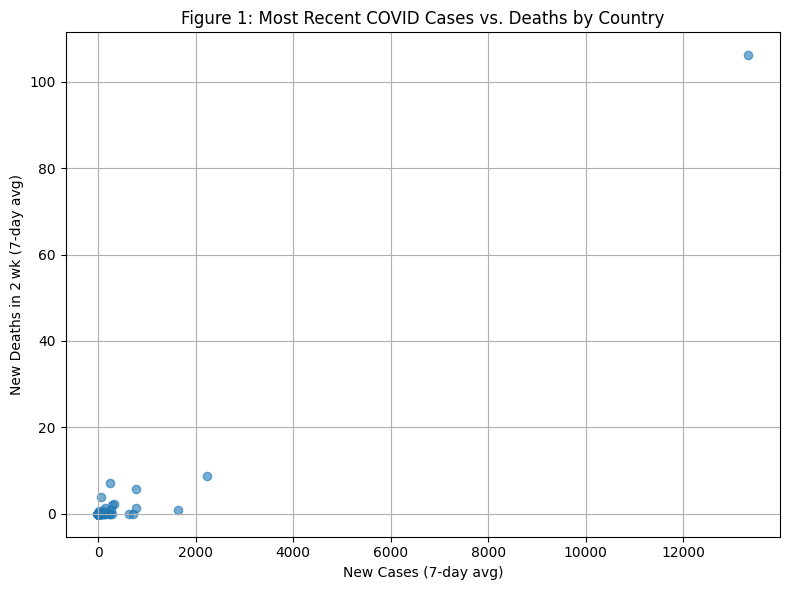

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df_plot = (
    df_final
    .loc[:, ['iso_code','date','new_cases_smoothed','new_deaths_smoothed_2wk']]
    .dropna(subset=['new_cases_smoothed','new_deaths_smoothed_2wk'])
)

latest = (
    df_plot
    .sort_values('date')
    .groupby('iso_code', as_index=False)
    .last()
)

plt.figure(figsize=(8,6))
plt.scatter(latest['new_cases_smoothed'], latest['new_deaths_smoothed_2wk'], alpha=0.6)
plt.xlabel('New Cases (7‐day avg)')
plt.ylabel('New Deaths in 2 wk (7‐day avg)')
plt.title('Figure 1: Most Recent COVID Cases vs. Deaths by Country')
plt.grid(True)
plt.tight_layout()
plt.show()


e) Scatterplot of only the most recent new deaths per day and the urban population


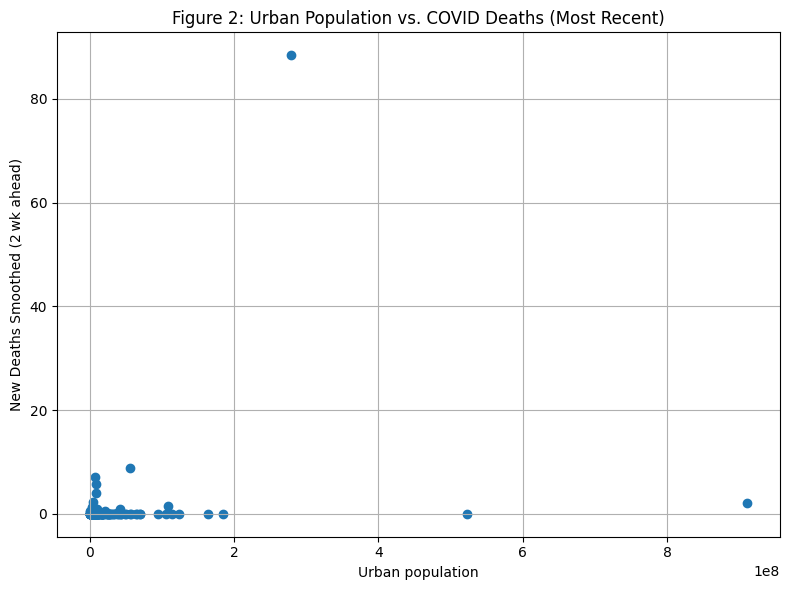

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

latest = (
    df_final
      .sort_values('date')
      .groupby('iso_code', as_index=False)
      .last()
)

urban_col = 'Urban population'

latest[urban_col] = pd.to_numeric(latest[urban_col], errors='coerce')

mask = latest[['new_deaths_smoothed_2wk', urban_col]].notna().all(axis=1)
latest_clean = latest[mask]

plt.figure(figsize=(8,6))
plt.scatter(latest_clean[urban_col], latest_clean['new_deaths_smoothed_2wk'])
plt.xlabel(urban_col)
plt.ylabel('New Deaths Smoothed (2 wk ahead)')
plt.title('Figure 2: Urban Population vs. COVID Deaths (Most Recent)')
plt.grid(True)
plt.tight_layout()
plt.show()


f) A table that shows the R2 and RMSE of the different models


|Model                                         |R^2    |RMSE  |
|----------------------------------------------|-------|------|
|M1:case+gdp+diaebetes +ICU                    | 0.885 |35.45 |
|M2: cases + elderly_ratio + diabetes + ICU    | 0.884 |35.30 |
|M3: cases_per_100k + elderly_ratio + log_gdp + diabetes                        | 0.055 |114.64|
|M4: cases + total_vaccinations + elderly_ratio| 0.287 |162.03|
|M5: cases_per_100k + log_gdp + elderly_pop_80_plus	                           | 0.185 |111.82|

g) A table that shows the RMSE of the best model for 20 most populous countries


In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error

best_name = min(rmses, key=rmses.get)
best_mod  = fitted_models[best_name]

def safe_rmse(grp):
    y_true = grp['new_deaths_smoothed_2wk']
    y_pred = best_mod.predict(grp)
    mask   = (~y_true.isna()) & (~pd.Series(y_pred, index=y_true.index).isna())
    if mask.sum() == 0:
        return np.nan
    return np.sqrt(mean_squared_error(y_true[mask], y_pred[mask]))

country_rmse = (
    test_data
      .groupby('iso_code')
      .apply(lambda grp: safe_rmse(grp))
      .reset_index(name='rmse')
)

country_rmse = country_rmse[country_rmse['rmse'].notna()]

pop_per_country = (
    df_final
      .sort_values('date')
      .groupby('iso_code', as_index=False)
      .last()[['iso_code','population']]
)

top20 = (
    country_rmse
      .merge(pop_per_country, on='iso_code')
      .sort_values('population', ascending=False)
      .head(20)
      .reset_index(drop=True)
)

print(f"Best model: {best_name} (RMSE = {rmses[best_name]:.2f})")
top20


<ipython-input-78-07e5937b484b>:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda grp: safe_rmse(grp))


Best model: M2_cases_elderly_diab_icu (RMSE = 35.30)


,iso_code,rmse,population
0,USA,62.072533,338289856
1,JPN,289.397593,123951696
2,DEU,47.646223,83369840
3,FRA,65.716792,67813000
4,ITA,14.541134,59037472
5,KOR,56.728961,51815808
6,ESP,8.027113,47558632
7,CAN,9.345101,38454328
8,MYS,19.871474,33938216
9,AUS,32.076477,26177410


h) A conclusion – what does your modeling say about death rates (e.g., what are the significant factors and what are not)

Case counts and elderly-population share are the strongest predictors of death rates two weeks later.
Model M2 (cases + elderly_ratio + diabetes + ICU) achieved the lowest test RMSE (35.30).
Interventions that reduce transmission and protect the elderly yield the greatest mortality reduction.

While model M4 (cases + total_vaccinations + elderly_ratio) achieved the highest
test RMSE(162.03)

Big RMSE number can indicate too much of a variation between the population where elders have received vaccination and there are elders that refuse to get vaccination. Since RMSE number is big, it is hard to make an accurate claim on what was the cause of the death rate.




In [ ]:
def colab2pdf():
  # @title Download Notebook in PDF Format{display-mode:'form'}
  !apt-get install -yqq --no-install-recommends librsvg2-bin>/dev/null;
  import contextlib,datetime,google,io,IPython,ipywidgets,json,locale,nbformat,os,pathlib,requests,urllib,warnings,werkzeug,yaml,re;locale.setlocale(locale.LC_ALL,'en_US.UTF-8');warnings.filterwarnings('ignore',category=nbformat.validator.MissingIDFieldWarning);
  %matplotlib inline
  def convert(b):
    try:
      s.value='🔄 Converting';b.disabled=True
      n=pathlib.Path(werkzeug.utils.secure_filename(urllib.parse.unquote(requests.get(f'http://{os.environ["COLAB_JUPYTER_IP"]}:{os.environ["KMP_TARGET_PORT"]}/api/sessions').json()[0]['name'])))
      p=pathlib.Path('/content/pdfs')/f'{datetime.datetime.utcnow().strftime("%Y%m%d_%H%M%S")}_{n.stem}';p.mkdir(parents=True,exist_ok=True);nb=nbformat.reads(json.dumps(google.colab._message.blocking_request('get_ipynb',timeout_sec=600)['ipynb']),as_version=4)
      u=[u for c in nb.cells if c.get('cell_type')=='markdown' for u in re.findall(r'!\[.*?\]\((https?://.*?)\)',c['source']) if requests.head(u,timeout=5).status_code!=200]
      if u:raise Exception(f"Bad Image URLs: {','.join(u)}")
      nb.cells=[cell for cell in nb.cells if '--Colab2PDF' not in cell.source]
      nb=nbformat.v4.new_notebook(cells=nb.cells or [nbformat.v4.new_code_cell('#')]);nbformat.validator.normalize(nb)
      nbformat.write(nb,(p/f'{n.stem}.ipynb').open('w',encoding='utf-8'))
      with (p/'config.yml').open('w', encoding='utf-8') as f: yaml.dump({'include-in-header':[{'text':r'\usepackage{fvextra}\DefineVerbatimEnvironment{Highlighting}{Verbatim}{breaksymbolleft={},showspaces=false,showtabs=false,breaklines,breakanywhere,commandchars=\\\{\}}'}],'include-before-body':[{'text':r'\DefineVerbatimEnvironment{verbatim}{Verbatim}{breaksymbolleft={},showspaces=false,showtabs=false,breaklines}'}]},f)
      !quarto render {p}/{n.stem}.ipynb --metadata-file={p}/config.yml --to pdf -M latex-auto-install -M margin-top=1in -M margin-bottom=1in -M margin-left=1in -M margin-right=1in --quiet
      google.colab.files.download(str(p/f'{n.stem}.pdf'));s.value=f'✅ Downloaded: {n.stem}.pdf'
    except Exception as e:s.value=f'❌ {str(e)}'
    finally:b.disabled=False
  if not pathlib.Path('/usr/local/bin/quarto').exists():
    !wget -q 'https://quarto.org/download/latest/quarto-linux-amd64.deb' && dpkg -i quarto-linux-amd64.deb>/dev/null && quarto install tinytex --update-path --quiet && rm quarto-linux-amd64.deb
  b=ipywidgets.widgets.Button(description='⬇️ Download');s=ipywidgets.widgets.Label();b.on_click(lambda b:convert(b));IPython.display.display(ipywidgets.widgets.HBox([b,s]))
colab2pdf() # | Colab2PDF v1.6 | https://github.com/drengskapur/colab2pdf | GPL-3.0-or-later |

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>